<a href="https://colab.research.google.com/github/eduardarsimoes/lae1/blob/main/Mania/Mania_Sprint3_AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Mania
---
Grupo: Eduarda Simões, Serenna Ferrari e Thaís de Souza

In [ ]:
# Installing pandas profiling
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Created wheel for pandas-profiling: filename=pandas_profiling-2.12.0-py2.py3-none-any.whl size=243829 sha256=2c1b028d3fc46f491140057f9e70d5b6fe25100b3c6bb431ed7843c9595f52b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-qfsmvyb2/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
Successfully built pandas-profiling


In [ ]:
!pip install dask distributed --upgrade
!pip install auto-sklearn

!apt-get install swig -y
!pip install Cython numpy
!pip install distributed
!pip install auto-sklearn==0.12.3
!pip install pydataset

Requirement already up-to-date: dask in /usr/local/lib/python3.7/dist-packages (2021.4.0)
Requirement already up-to-date: distributed in /usr/local/lib/python3.7/dist-packages (2021.4.0)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [ ]:
# Importing needed libraries
import pandas as pd
import sklearn 
import numpy as np
import seaborn as sns

import pandas_profiling 

from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

import autosklearn.classification

In [ ]:
# Importing data and creating dataset
url = "https://raw.githubusercontent.com/eduardarsimoes/lae1/main/Mania/Variaveis_Mania%2BSC%2BCC.csv"
dataset = pd.read_csv(url, header=0, sep = ";")

pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.max_rows', None)

# Drop de colunas

In [ ]:
#Retirando as colunas que estão zeradas
dataset.drop(["CC2A04","CC2A05","CC2A06", "CC2A07", "CC2A08", "CC2A09", "CC2A10", "CC2A11", "CC2A12"], axis = 1, inplace = True)

#Retirando as colunas que não sabemos a resposta/pergunta
dataset.drop(["SC1_1", "SC3A", "SC9", "SC19", "SC20A", "SC20_1", "SC20_2", "SC20_3",\
              "SC21", "SC22", "SC29A", "SC33_1", "SC33_2", "SC33_3", "CC2", "CC2A01", \
              "CC2A02", "CC2A03", "CC3", "CC3A", "CC4", "CC5", "CC50A", "CC50B", "CC50C", \
              "CC50D", "CC50E", "CC50I", "CC51", "CC52", "CC53", "CC54"], axis = 1, inplace = True)

In [ ]:
#Função para retirar e printar quais colunas foram retiradas por possuírem uma 
#Correlação maior que o threshold
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (abs(corr_matrix.iloc[i, j]) >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                colname2 = corr_matrix.columns[j] # getting the name of column
                # Não retira colunas que impactem muito na variável target
                if(colname != 'dsm_man' and colname2 != 'dsm_man'):
                  col_corr.add(colname)
                  if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    print(col_corr, len(col_corr))

# Chamando a função para retirar colunas com 85% de correlação entre si
correlation(dataset, 0.85)

{'M55', 'M19A', 'M33A', 'M48_1', 'CC10D', 'M19D', 'SC25A', 'SC26B', 'CC23', 'M30A', 'M18', 'M6', 'M27D', 'M3D1', 'M27A', 'M30C', 'M47', 'M48A', 'CC30', 'M23', 'M45B', 'M45C', 'CC31B', 'M18D1', 'M30F', 'M45A', 'M22A', 'M48', 'M18C', 'M18B', 'M30H', 'M27C', 'CC26C', 'M29', 'M26'} 35


# Drop de linhas

In [ ]:
#Excluindo linhas que não há resposta para nenhuma pergunta específica de Mania
man_cols = dataset.columns[dataset.columns.slice_indexer('M1','M54')]
dataset = dataset.dropna(subset=man_cols, axis=0, how="all")

#Verificando balanceamento após remoção de linhas
print(dataset.groupby('dsm_man').size())
dataset.shape

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


dsm_man
1     35
5    673
dtype: int64


(708, 153)

# Oversampling

Random over-sampling:
5    673
1    673
Name: dsm_man, dtype: int64


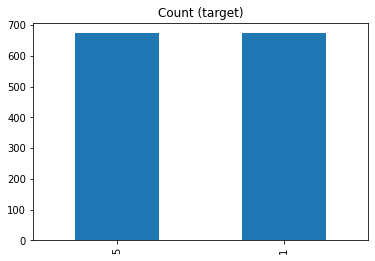

In [ ]:
# Oversampling
# Class count
count_class_0, count_class_1 = dataset['dsm_man'].value_counts()

# Divide by class
# Has mania, minority class
df_class_1 = dataset[dataset['dsm_man'] == 1]
# Doesn't have, majority
df_class_0 = dataset[dataset['dsm_man'] == 5]

df_class_1_over = df_class_1.sample(count_class_0, replace=True, random_state = 42)
dataset_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(dataset_over['dsm_man'].value_counts())

dataset_over['dsm_man'].value_counts().plot(kind='bar', title='Count (target)');


# Separando e pre processando variáveis


In [ ]:
dataset_over.ffill(inplace=True)
X = dataset_over.drop(columns='dsm_man')
Y = dataset_over['dsm_man']
X_number = X.describe(include=np.number).columns
# Error: no categoricals
# X_category = X.describe(include=np.object).columns
# convert_cat = dataset_over[X_category].astype('category')
# dum_caterogy = pd.get_dummies(convert_cat)
X_num_cat = pd.concat([dataset_over[X_number]], axis=1)
X_num_cat.fillna(method='bfill', inplace=True)
X_num_cat

M1  M1A   M3    M3A   M3B1  M3B2    M3C  M3D2   M4   M5    M6A   M6B1  \
8     5.0  1.0  5.0   30.0    1.0   3.0   12.0   4.0  5.0  1.0   25.0   20.0   
10    5.0  1.0  5.0   30.0    1.0   3.0   12.0   4.0  5.0  5.0   25.0   20.0   
11    5.0  1.0  5.0   30.0    1.0   3.0   12.0   4.0  5.0  1.0   44.0    6.0   
16    5.0  1.0  5.0   30.0    1.0   3.0   12.0   4.0  5.0  5.0   44.0    6.0   
37    5.0  1.0  5.0   30.0    1.0   3.0   12.0   4.0  5.0  1.0   44.0    2.0   
38    1.0  1.0  5.0   30.0    1.0   3.0   12.0   4.0  5.0  1.0   44.0    2.0   
40    1.0  1.0  5.0   30.0    1.0   3.0   33.0   2.0  1.0  1.0   44.0    2.0   
44    1.0  1.0  5.0   30.0    1.0   3.0   33.0   2.0  1.0  1.0   44.0    2.0   
49    1.0  1.0  5.0   30.0    1.0   3.0   33.0   2.0  1.0  5.0   44.0    2.0   
50    1.0  1.0  5.0   30.0    1.0   3.0   33.0   2.0  1.0  5.0   44.0    2.0   
54    1.0  1.0  5.0   30.0    1.0   3.0   33.0   2.0  1.0  5.0   44.0    2.0   
55    1.0  1.0  5.0   30.0    1.0   3.0   33.0   2.0  1.0  1.0   48.0    7.0   
92    1.0  1.0  5.0   30.0    1.0   3.0   33.0   2.0  1.0  5.0   48.0    7.0   
107   1.0  1.0  5.0   30.0    1.0   3.0   33.0   2.0  1.0  1.0   37.0    6.0   
116   1.0  1.0  5.0   30.0    1.0   3.0   33.0   2.0  1.0  1.0   37.0    6.0   
121   1.0  1.0  5.0   30.0    1.0   3.0   33.0   2.0  1.0  5.0   37.0    6.0   
132   1.0  1.0  5.0   30.0    1.0   3.0   33.0   2.0  1.0  5.0   37.0    6.0   
136   1.0  1.0  5.0   30.0    1.0   3.0   33.0   2.0  1.0  5.0   37.0    6.0   
146   1.0  1.0  5.0   30.0    1.0   3.0   33.0   2.0  1.0  5.0   37.0    6.0   
147   1.0  1.0  5.0   30.0    1.0   3.0   33.0   2.0  1.0  5.0   37.0    6.0   
157   1.0  1.0  5.0   30.0    1.0   3.0   33.0   2.0  1.0  5.0   37.0    6.0   
164   1.0  1.0  5.0   30.0    1.0   3.0   33.0   2.0  1.0  5.0   37.0    6.0   
172   5.0  2.0  5.0   30.0    1.0   3.0   33.0   2.0  1.0  5.0   37.0    6.0   
176   1.0  2.0  1.0   30.0    1.0   3.0   33.0   2.0  5.0  5.0   37.0    6.0   
186   1.0  2.0  5.0   30.0    1.0   3.0  998.0   2.0  5.0  5.0   37.0    6.0   
193   1.0  2.0  5.0   30.0    1.0   3.0  998.0   2.0  5.0  5.0   37.0    6.0   
194   1.0  2.0  5.0   30.0    1.0   3.0  998.0   2.0  5.0  5.0   37.0    6.0   
198   1.0  2.0  5.0   30.0    1.0   3.0  998.0   2.0  5.0  5.0   37.0    6.0   
205   1.0  2.0  5.0   30.0    1.0   3.0  998.0   2.0  5.0  5.0   37.0    6.0   
206   1.0  2.0  5.0   30.0    1.0   3.0  998.0   2.0  5.0  5.0   37.0    6.0   
207   1.0  2.0  5.0   30.0    1.0   3.0  998.0   2.0  5.0  5.0   37.0    6.0   
209   1.0  2.0  5.0   30.0    1.0   3.0  998.0   2.0  5.0  1.0   37.0    6.0   
210   1.0  2.0  5.0   30.0    1.0   3.0  998.0   2.0  5.0  5.0   37.0    6.0   
220   1.0  2.0  5.0   30.0    1.0   3.0  998.0   2.0  5.0  5.0   37.0    6.0   
235   1.0  2.0  5.0   30.0    1.0   3.0  998.0   2.0  5.0  5.0   37.0    6.0   
262   1.0  2.0  5.0   30.0    1.0   3.0  998.0   2.0  5.0  1.0   37.0    6.0   
285   1.0  2.0  5.0   30.0    1.0   3.0   38.0   3.0  1.0  1.0   37.0    6.0   
286   5.0  2.0  5.0   30.0    1.0   3.0   38.0   3.0  1.0  1.0   37.0    6.0   
289   1.0  2.0  5.0   30.0    1.0   3.0   30.0   2.0  5.0  1.0   37.0    6.0   
299   1.0  2.0  5.0   30.0    1.0   3.0   30.0   2.0  5.0  1.0   37.0    6.0   
304   1.0  2.0  5.0   30.0    1.0   3.0   30.0   2.0  5.0  1.0   18.0    2.0   
310   1.0  2.0  5.0   30.0    1.0   3.0   30.0   2.0  5.0  5.0   18.0    2.0   
311   1.0  2.0  5.0   30.0    1.0   3.0   30.0   2.0  5.0  1.0  998.0  998.0   
312   1.0  2.0  5.0   30.0    1.0   3.0   30.0   2.0  5.0  5.0  998.0  998.0   
322   1.0  2.0  1.0   19.0   21.0   5.0   30.0   2.0  1.0  5.0  998.0  998.0   
323   1.0  2.0  5.0   19.0   21.0   5.0  998.0   2.0  5.0  5.0  998.0  998.0   
338   1.0  2.0  5.0   19.0   21.0   5.0  998.0   2.0  5.0  1.0  998.0  998.0   
347   1.0  2.0  5.0   19.0   21.0   5.0  998.0   2.0  5.0  1.0   18.0    1.0   
348   1.0  2.0  5.0   19.0   21.0   5.0  998.0   2.0  5.0  5.0   18.0    1.0   
350   1

In [ ]:
best_ds = X_num_cat
stat_data = best_ds.describe(include='all').T
stat_data['nulos'] = pd.DataFrame(best_ds.isnull().sum())
stat_data['percent_nulos'] = pd.DataFrame(best_ds.isna().mean().round(4) * 100)
stat_data

count        mean         std   min   25%   50%    75%    max  nulos  \
M1     1346.0    2.283804    1.899635   1.0   1.0   1.0    5.0    9.0      0   
M1A    1346.0    1.418276    0.493459   1.0   1.0   1.0    2.0    2.0      0   
M3     1346.0    1.948737    1.715762   1.0   1.0   1.0    1.0    8.0      0   
M3A    1346.0   58.459138  177.040878  12.0  18.0  26.0   30.0  998.0      0   
M3B1   1346.0   55.343239  215.954314   1.0   1.0   4.0    8.0  998.0      0   
M3B2   1346.0    3.888559    1.011930   1.0   3.0   4.0    5.0    5.0      0   
M3C    1346.0  111.484398  246.010336  12.0  38.0  51.0   51.0  998.0      0   
M3D2   1346.0    2.843982    0.694769   1.0   2.0   3.0    3.0    4.0      0   
M4     1346.0    3.119614    2.039707   1.0   1.0   5.0    5.0    8.0      0   
M5     1346.0    2.047548    1.798999   1.0   1.0   1.0    5.0    9.0      0   
M6A    1346.0   71.708024  191.509985  10.0  24.0  34.0   41.0  998.0      0   
M6B1   1346.0  101.054978  293.422210   1.0   2.0   4.0    8.0  998.0      0   
M6B2   1346.0    4.144131    1.074904   1.0   4.0   5.0    5.0    5.0      0   
M6C    1346.0   65.115899  182.256651   1.0  18.0  27.0   47.0  998.0      0   
M6D1   1346.0   70.127043  248.530374   1.0   2.0   3.0    3.0  998.0      0   
M6D2   1346.0    2.810550    1.223892   1.0   2.0   2.0    4.0    5.0      0   
M7A    1346.0    1.953195    1.709377   1.0   1.0   1.0    1.0    8.0      0   
M7B    1346.0    4.176077    1.771159   1.0   5.0   5.0    5.0    9.0      0   
M7C    1346.0    2.953938    2.062075   1.0   1.0   1.0    5.0    9.0      0   
M7D    1346.0    2.748886    1.998721   1.0   1.0   1.0    5.0    9.0      0   
M7E    1346.0    3.054978    2.031340   1.0   1.0   5.0    5.0    9.0      0   
M7F    1346.0    2.372957    1.940907   1.0   1.0   1.0    5.0    9.0      0   
M7G    1346.0    2.163447    1.950320   1.0   1.0   1.0    5.0    9.0      0   
M7H    1346.0    2.279346    1.899905   1.0   1.0   1.0    5.0    9.0      0   
M7I    1346.0    1.861070    1.696491   1.0   1.0   1.0    1.0    9.0      0   
M7J    1346.0    2.127043    1.839120   1.0   1.0   1.0    5.0    9.0      0   
M7K    1346.0    3.930906    1.810456   1.0   1.0   5.0    5.0    9.0      0   
M7L    1346.0    2.500000    1.965596   1.0   1.0   1.0    5.0    9.0      0   
M7M    1346.0    3.265230    2.018559   1.0   1.0   5.0    5.0    9.0      0   
M7N    1346.0    2.990342    2.028216   1.0   1.0   1.0    5.0    9.0      0   
M7O    1346.0    3.867013    1.833435   1.0   1.0   5.0    5.0    9.0      0   
M8     1346.0    1.097325    0.296511   1.0   1.0   1.0    1.0    2.0      0   
M9     1346.0    3.173105    1.188754   1.0   2.0   3.0    4.0    9.0      0   
M9A    1346.0    2.138187    1.114386   1.0   1.0   2.0    3.0    4.0      0   
M9B    1346.0    1.526003    1.352291   1.0   1.0   1.0    1.0    5.0      0   
M10A   1346.0    3.154532    2.041185   1.0   1.0   5.0    5.0    8.0      0   
M10B   1346.0    2.417533    2.148285   1.0   1.0   1.0    5.0    9.0      0   
M10D   1346.0    4.280832    1.536627   1.0   5.0   5.0    5.0    5.0      0   
M18A   1346.0   40.827637  112.095207   5.0  18.0  28.0   35.0  998.0      0   
M18D2  1346.0    4.139673    0.996552   1.0   4.0   4.0    5.0    5.0      0   
M19    1346.0    2.708767    1.979418   1.0   1.0   1.0    5.0    5.0      0   
M19B   1346.0  250.694651  419.796311   1.0   1.0   4.0  240.0  999.0      0   
M19C   1346.0  278.359584  425.780471   1.0   4.0  28.0  998.0  999.0      0   
M20    1346.0  298.080981  453.822206   0.0   1.0   3.0  998.0  998.0      0   
M21    1346.0  418.279346  489.631415   0.0   0.0  10.0  998.0  998.0      0   
M21A   1346.0    1.763001    0.425399   1.0   2.0   2.0    2.0    2.0      0   
M21_1  1346.0  388.416048  483.134275   0.0   1.0  12.0  998.0  998.0      0   
M22B   1346.0    3.810550    1.079271   1.0   3.0   4.0    5.0    5.0      0   
M27B   1346.0   13.699851   28.186669   0.0   0.0   5.0    9.0   98.0      0   
M28    1

In [ ]:
#Selecting the best 30 characteristics
sel_            = SelectKBest(chi2, k = 30).fit(X_num_cat, Y)
best_attributes = list(X_num_cat.columns[sel_.get_support()])
best_df         = X_num_cat[best_attributes]
print(best_attributes)

X_train, X_test, Y_train, Y_test = train_test_split(best_df, Y, test_size=0.25, random_state=42, shuffle=True)
print("Dados treino: {}".format(X_train.shape))
print("Dados teste: {}".format(X_test.shape))

['M3', 'M3A', 'M3B1', 'M3C', 'M5', 'M6A', 'M6B1', 'M6C', 'M6D1', 'M7D', 'M7L', 'M7N', 'M18A', 'M19B', 'M19C', 'M20', 'M21', 'M21_1', 'M30B', 'M30E', 'M30I', 'M30K', 'CC9', 'CC12', 'CC33', 'CC34', 'CC35', 'CC49A', 'CC49C', 'CC49D']
Dados treino: (1009, 30)
Dados teste: (337, 30)


#AutoML com auto-sklearn

In [ ]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task = 120,
    per_run_time_limit = 30,
    tmp_folder='/tmp/autosklearn_classification_example_tmp'
)
automl.fit(X_train, Y_train)

'/tmp/autosklearn_classification_example_out'

In [ ]:
predictions = automl.predict(X_test)


#CRIANDO A MATRIZ DE CONFUSÃO E REPORT
matrix    = confusion_matrix(Y_test, predictions)

print('==== Conf. Matrix ====')
print(matrix)

report = classification_report(Y_test, predictions)
print('\n==== Report ====')
print(report)

==== Conf. Matrix ====
[[198   0]
 [  0 206]]

==== Report ====
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       198
           5       1.00      1.00      1.00       206

    accuracy                           1.00       404
   macro avg       1.00      1.00      1.00       404
weighted avg       1.00      1.00      1.00       404



In [ ]:
print('Accuracy score:  ', sklearn.metrics.accuracy_score(Y_test, predictions))
print('Accuracy AUC:    ', sklearn.metrics.roc_auc_score(Y_test, predictions))
print('Precision score: ', sklearn.metrics.precision_score(Y_test, predictions))
print('Recall score:    ', sklearn.metrics.recall_score(Y_test, predictions))
print('F1 score:        ', sklearn.metrics.f1_score(Y_test, predictions))

Accuracy score:   1.0
Accuracy AUC:   1.0
Precision score:  1.0
Recall score:     1.0
F1 score:         1.0


In [ ]:
#GENERATE THE PROFILING REPORT (EDA)
best_df = pd.concat([X_num_cat, Y], axis=1)
best_df.reset_index(drop=True, inplace=True)
profile = pandas_profiling.ProfileReport(
    best_df, 
    title         = "Mania Dataset", 
    html          = {"style": {"full_width": True}}, sort="None",
    correlations  = {"cramers": {"calculate": False}}, minimal = True) 
profile.to_file('mania_done.html')

Summarize dataset:   0%|          | 0/161 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]